## Colorization photos

Based on Tutorial : https://emilwallner.medium.com/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d 

In [25]:
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [13]:
# Get images
X = []
for filename in os.listdir('./Train/'):
    X.append(img_to_array(load_img('./Train/'+filename)))
X = np.array(X, dtype=float)

# Set up train and test data
split = int(0.95*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain

In [14]:
model = Sequential()
model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='rmsprop', loss='mse')

In [ ]:
# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 10
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

# Train model      
tensorboard = TensorBoard(log_dir="output/first_run")

In [5]:
model.fit_generator(image_a_b_gen(batch_size), callbacks=[tensorboard], epochs=5, steps_per_epoch=10000)

/tmp/ipykernel_4102/3246492952.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(image_a_b_gen(batch_size), callbacks=[tensorboard], epochs=5, steps_per_epoch=10000)


Epoch 1/5
10000/10000 [==============================] - 30081s 3s/step - loss: 0.0018
Epoch 2/5
10000/10000 [==============================] - 29981s 3s/step - loss: 2.8155e-04
Epoch 3/5
10000/10000 [==============================] - 30009s 3s/step - loss: 2.5725e-04
Epoch 4/5
10000/10000 [==============================] - 30107s 3s/step - loss: 2.4714e-04
Epoch 5/5
10000/10000 [==============================] - 29807s 3s/step - loss: 2.3988e-04


In [6]:
# Save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [17]:
#load model
batch_size = 10
from keras.models import load_model
model.load_weights('./model.h5')

In [18]:
# Test images
Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print(model.evaluate(Xtest, Ytest, batch_size=batch_size))

1/1 [==============================] - 0s 277ms/step - loss: 0.0065
0.006455805152654648


In [26]:
color_me = []
photo_list = sorted(os.listdir('./Test/'))
for filename in photo_list:
    color_me.append(img_to_array(load_img('./Test/'+filename)))
color_me = np.array(color_me, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

# Test model
output = model.predict(color_me)
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    cur[:,:,1:] = output[i]
    imsave("./result_CNN/img_"+str(i)+".png", lab2rgb(cur))


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


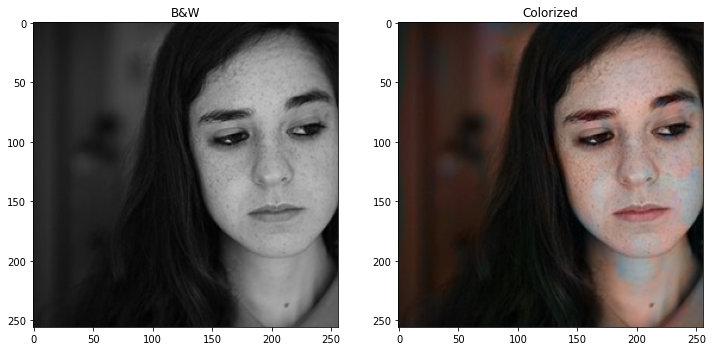

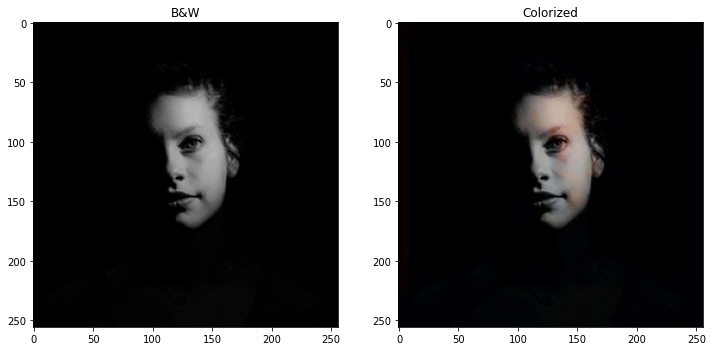

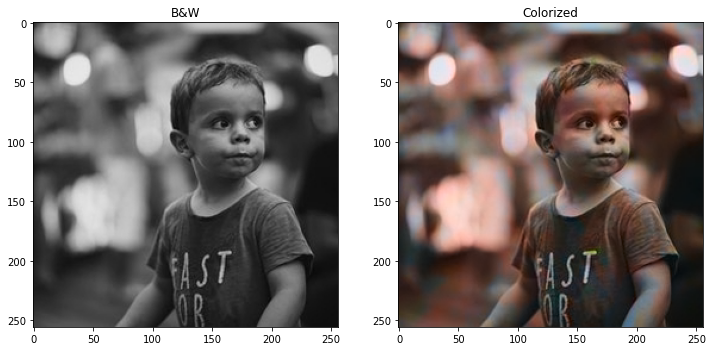

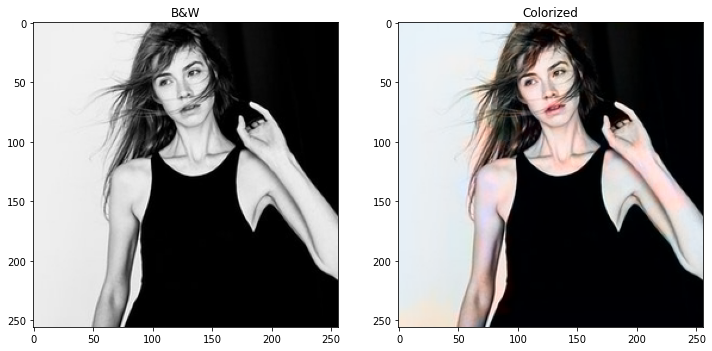

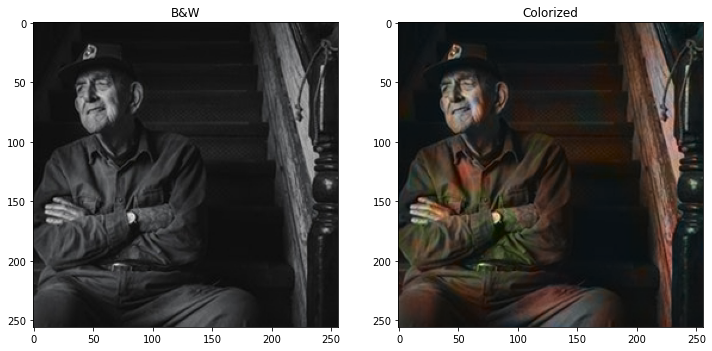

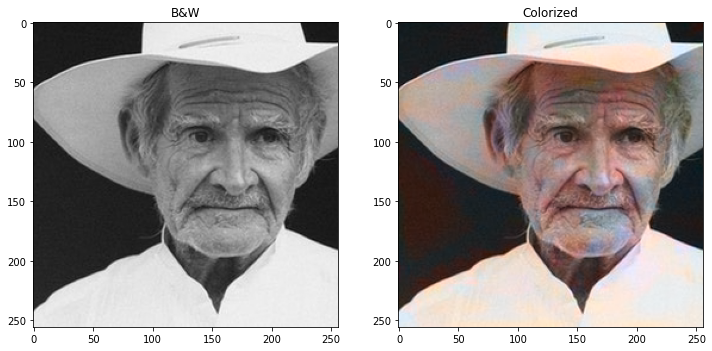

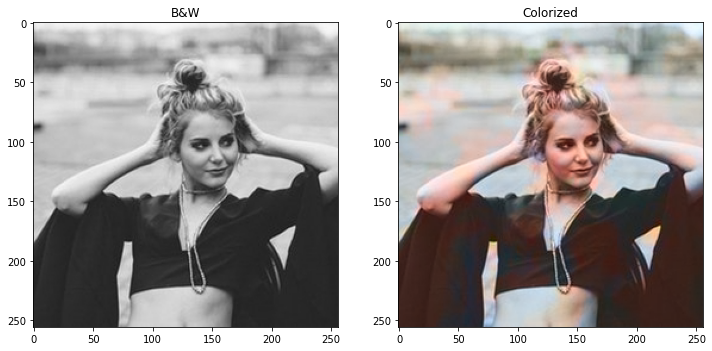

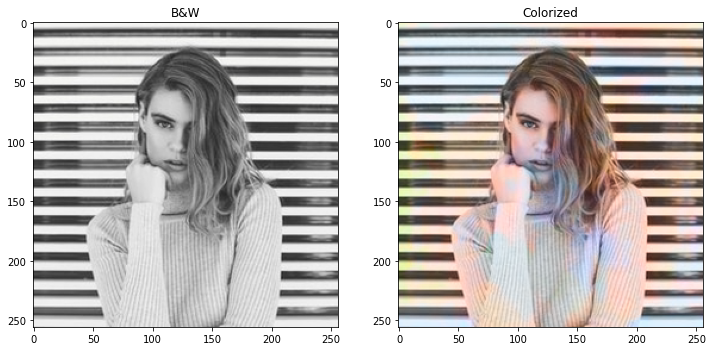

In [27]:
#Visualization result 
import matplotlib.pyplot as plt   

tst = sorted(os.listdir('./Test/'))
res = sorted(os.listdir('./result_CNN/'))

for i in range (0, len(res)):

   source = load_img('./Test/'+tst[i])
   result = load_img('./result_CNN/'+res[i])

   fig = plt.figure(figsize=(12,12))

   ax = fig.add_subplot(1,2,1)
   ax.set_title('B&W')
   imgplt = plt.imshow(source)
   ax = fig.add_subplot(1,2,2)
   ax.set_title('Colorized')
   imgplt = plt.imshow(result)

plt.show()